# Time Series: Building to ARIMA Modeling

## Objectives

- Build simple models for time series data
- Explain auto-regressive and moving-average models
- Build time-series models with `statsmodels`


In [1]:
# Initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split

## Set Up

Our data will be monthly passenger data for airlines.

In [2]:
# Read in our data
df = pd.read_csv('data/airline_passengers.csv')

df.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Now What?

We should do a few things to explore (plot) and prep our data. Any ideas?

- Set the datetime index
- Explore for outliers/nulls
- Visualize our data
- Check stationarity


In [3]:
# Your code here!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    144 non-null    object
 1   Thousands of Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df['Month'] = pd.to_datetime(df['Month'])

In [5]:
df = df.set_index('Month')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


<AxesSubplot:xlabel='Month'>

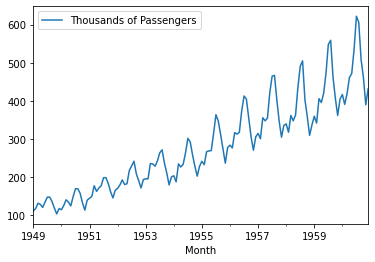

In [7]:
# More room for exploratory or preparatory code
df.plot()

#### Observations:

- Seasonality - repeated pattern
- Upward trend - hard to tell if linear or exponential (additive or multiplicative)
- Heteroskedasticity

aka NOT stationary

In [8]:
# Make sure to decompose
from statsmodels.tsa.seasonal import seasonal_decompose

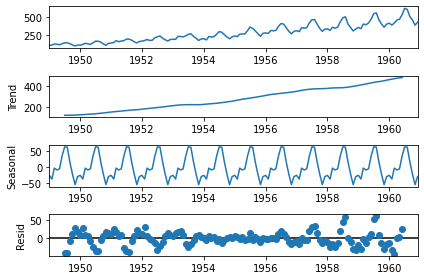

In [9]:
# And more room for code!
decomp = seasonal_decompose(df)
decomp.plot();

In [10]:
# May want to check the index frequency, don't want freq=None
df.index.freq = 'MS'

In [11]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [12]:
# And check for stationarity!
adfuller(df)

(0.8153688792060472,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

FAIL TO REJECT!

Because .99 > .05

### Train Test Split

We're modeling, so we'll want to reserve some data as a test set.

But, there are special considerations for time-dependent data! Namely: we NEVER want to use the future in our training data - we need to be sure we're only ever learning from the past!

When developing a time series model, **we can't split our data randomly**, since the whole point is to make use of values that are near in time to other values. Typically we'll train on the earlier data points and test on the later ones.

Instead, we'll use **fixed partitioning** to designate sections for training and testing (with maybe a hold out set as well)

![](images/train-valid-test.png)



In addition to not shuffling our data when splitting, this will look different than our past uses of `train_test_split` because we don't really have an X and y in this case. Instead, we're using the past as our X, to predict the future.

One more note: when truly forecasting for the future, we'll want to retrain our models (using the parameters found during our modeling process) on ALL of the data available, since we'll want the end of the test set (last available data) when predicting out into the future.

> Bonus: If we want to cross-validate our time series, sklearn has that built out: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data
>
> This implements something called **roll-forwarding** (as opposed to fixed partitioning), which incrementally includes more data as the train and then evaluating on the next portion as test.
>
> Potentially useful additional resource on this: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

What we need to ask ourselves now is: how much do we want to save as test data?

In [13]:
# We can manually train test split
train = df[:'1957']
test = df['1958':]

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 1949-01-01 to 1957-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  108 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1958-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  36 non-null     int64
dtypes: int64(1)
memory usage: 576.0 bytes


In [16]:
# Or we can use sklearn's train_test_split with shuffle=False
train_test_split(df, test_size = 36, shuffle=False)

[            Thousands of Passengers
 Month                              
 1949-01-01                      112
 1949-02-01                      118
 1949-03-01                      132
 1949-04-01                      129
 1949-05-01                      121
 ...                             ...
 1957-08-01                      467
 1957-09-01                      404
 1957-10-01                      347
 1957-11-01                      305
 1957-12-01                      336
 
 [108 rows x 1 columns],
             Thousands of Passengers
 Month                              
 1958-01-01                      340
 1958-02-01                      318
 1958-03-01                      362
 1958-04-01                      348
 1958-05-01                      363
 1958-06-01                      435
 1958-07-01                      491
 1958-08-01                      505
 1958-09-01                      404
 1958-10-01                      359
 1958-11-01                      310
 1958-12-01

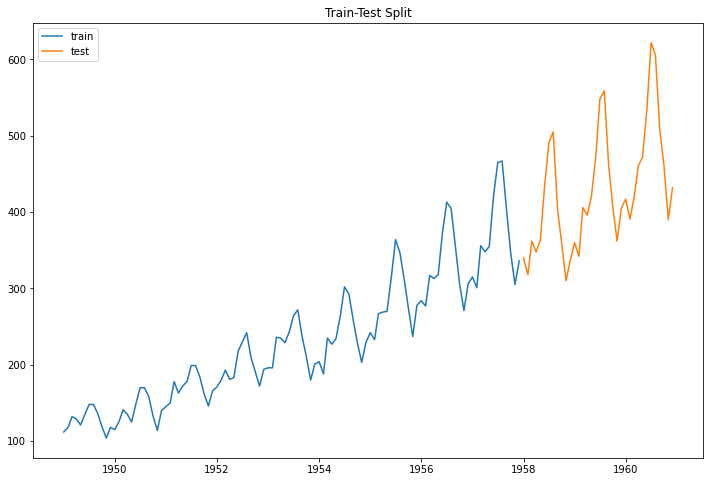

In [17]:
# Let's visualize our train and test sets
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

### Set Up an Evaluate Function

Bonus for y'all! Here's a quick function to explore a few metrics on our time series predictions.

Note! We're back to regression!

In [18]:
from sklearn import metrics

def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))

You'll also often see time series models evaluated using Information Criterion, namely AIC or BIC. These are relative ways to explore which models comparatively perform better. A better model will have a lower AIC.

## Initial Modeling Approaches - Modelless Baselines!

#### What's the most naive way to make a prediction here? 

(searching for a very dumb approach - think our modelless baselines back in phase 2!)

- 


In [19]:
# Let's implement it! Make our predictions for our test set
train_mean = train.mean()[0]
train_mean

230.89814814814815

In [20]:
preds_baseline = [train_mean] * len(test)

In [21]:
# Then evaluate
report_metrics(test, preds_baseline)

Explained Variance:
	 0.0
MAE:
	 197.60185185185188
RMSE:
	 212.52011060329505
r^2:
	 -6.381912688199452


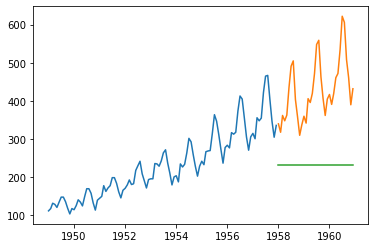

In [22]:
plt.plot(train)
plt.plot(test)
plt.plot(pd.Series(preds_baseline, index=test.index));

#### Can we think of another naive way to approach these predictions?

(hint: `shift`)

- 


In [23]:
# Implement another method!
shift_1_preds = df.shift()['1958':]
shift_1_preds.head()

,Thousands of Passengers
Month,
1958-01-01,336.0
1958-02-01,340.0
1958-03-01,318.0
1958-04-01,362.0
1958-05-01,348.0


In [24]:
# Then evaluate
report_metrics(test, shift_1_preds)

Explained Variance:
	 0.5876400056297358
MAE:
	 42.333333333333336
RMSE:
	 50.299657608730854
r^2:
	 0.5864777375725849


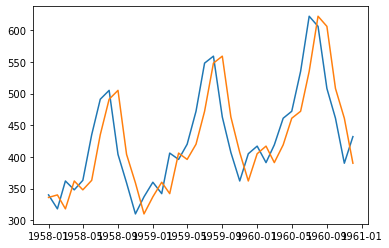

In [25]:
# plt.plot(train)
plt.plot(test)
plt.plot(shift_1_preds);

In [26]:
df.shift(12).head(13)

,Thousands of Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [27]:
shift_12_preds = df.shift(12)["1958":]

In [28]:
test.head(3)

,Thousands of Passengers
Month,
1958-01-01,340
1958-02-01,318
1958-03-01,362


In [29]:
shift_12_preds.head(3)

,Thousands of Passengers
Month,
1958-01-01,315.0
1958-02-01,301.0
1958-03-01,356.0


In [30]:
report_metrics(test, shift_12_preds)

Explained Variance:
	 0.9228147317476244
MAE:
	 35.916666666666664
RMSE:
	 41.97916149710473
r^2:
	 0.7119709069776945


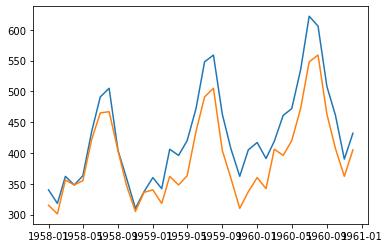

In [31]:
# plt.plot(train)
plt.plot(test)
plt.plot(shift_12_preds);

<AxesSubplot:xlabel='Month'>

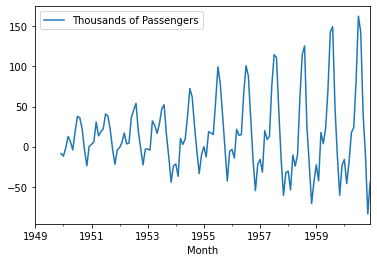

In [32]:
(df - df.rolling(window=12).mean()).plot()

<AxesSubplot:xlabel='Month'>

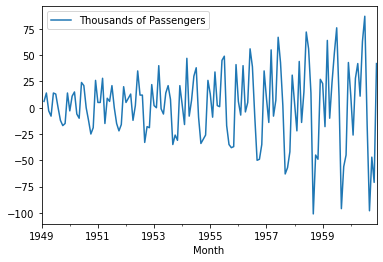

In [33]:
df.diff().plot()

## The ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **AutoRegressive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

Let's have a quick introduction to ARIMA. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:


A note - we can build individual AR models, or MA models, or just ARMA models. 

In practice, our raw time series data will not be stationary (like, ever), and the general strategy will be to take _differences_ to try to get a stationary series.

If the first-order differences of consecutive terms *themselves* do not form a stationary series, then the typical move is to consider *second-order* differences, i.e. differences of the differences.

It would be nice to have a modeling algorithm that would do our differencing for us. That is the point of **ARIMA** models. The 'I' stands for **integrated**, and the `statsmodels` tool will let us specify, in addition to the number of AR and MA terms, also the degree of difference on our raw data series that we want to use.

### Number of AR (Auto-Regressive) terms (`p`): 

`p` is the **auto-regressive** part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just *lags* of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

### Number of Differences (`d`):

`d` is the **Integrated** component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last *n* days is small. 

### Number of MA (Moving Average) terms (`q`): 

`q` is the **moving average** part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where `e(i)` is the difference between the moving average at ith instant and actual value.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. 

A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. There are several manual ways to tune our ARIMA models, and later we'll explore how we can grid search these parameters as well!

#### Let's test it out!

[Documentation](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html)

In [34]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [35]:
# From our data exploration earlier, what do we want to use as params?
# Order will be (p,d,q)
arima_order = (1, 1, 1) # should be a tuple, like (0,0,0)

In [36]:
# Now let's fit our ARIMA model
arima_1 = ARIMA(train, order=arima_order)

result = arima_1.fit()

In [37]:
# Same as:
# result = ARIMA(train, order=arima_order).fit()

In [38]:
# Since it's statsmodels, we have a summary we can explore
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                  108
Model:                      ARIMA(1, 1, 1)   Log Likelihood                -490.640
Date:                     Tue, 26 Jul 2022   AIC                            987.280
Time:                             15:36:24   BIC                            995.299
Sample:                         01-01-1949   HQIC                           990.531
                              - 12-01-1957                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4856      0.136     -3.567      0.000      -0.752      -0.219
ma.L1          0.8760      0.078     11.289      0.000       0.724       1.028
sigma2       559.5788     94.858      5.899      0.000     373.661     745.496
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.80   Prob(JB):                         0.42
Heteroskedasticity (H):               4.60   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
result.aic

987.2800406314705

In [40]:
# We can also make predictions using .forecast
# Steps will be the length of our test data
test_preds = result.forecast(steps=len(test))

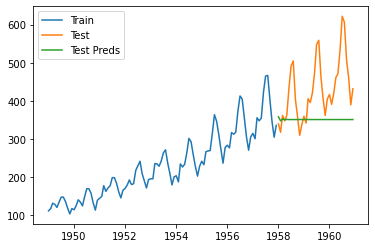

In [41]:
# How can we visualize our predictions?
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(test_preds, label = 'Test Preds')
plt.legend();

In [42]:
# Evaluate
report_metrics(test, test_preds)

Explained Variance:
	 -0.003347584283385441
MAE:
	 83.49526667592285
RMSE:
	 109.89878137312697
r^2:
	 -0.9740338297310933


## Random Walk Model

We can compare to a model with only a single differencing term, which is called a random walk model.

In [43]:
# Create our random walk model
# Order will be (p,d,q)
rw_order = (0,1,0) # should be a tuple, like (0,0,0)

# Then fit
rw_res = ARIMA(train, order=rw_order).fit()

In [44]:
# Check out the summary
rw_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                  108
Model:                      ARIMA(0, 1, 0)   Log Likelihood                -499.765
Date:                     Tue, 26 Jul 2022   AIC                           1001.531
Time:                             15:36:24   BIC                           1004.204
Sample:                         01-01-1949   HQIC                          1002.614
                              - 12-01-1957                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       667.5082     94.937      7.031      0.000     481.435     853.581
===================================================================================
Ljung-Box (L1) (Q):                   8.33   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.00   Prob(JB):                         0.95
Heteroskedasticity (H):               5.78   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Get predictions out
rw_preds = rw_res.forecast(steps=len(test), typ='levels')

In [46]:
# Evaluate
report_metrics(test, rw_preds)

Explained Variance:
	 0.0
MAE:
	 94.94444444444444
RMSE:
	 121.13857996342682
r^2:
	 -1.398467258999632


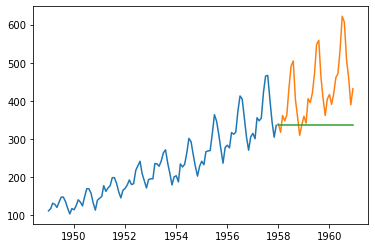

In [47]:
# How can we visualize our predictions?
plt.plot(train)
plt.plot(test)
plt.plot(rw_preds)

## One More ARIMA Model

Let's try another ARIMA model, with different terms than before

In [48]:
# Create our next ARIMA model
# Order will be (p,d,q)
arima_order_2 = (2,2,2) # should be a tuple, like (0,0,0)

# Then fit
result_2 = ARIMA(train, order=arima_order_2).fit()

/opt/anaconda3/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
# Check out the summary
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                  108
Model:                      ARIMA(2, 2, 2)   Log Likelihood                -488.048
Date:                     Tue, 26 Jul 2022   AIC                            986.096
Time:                             15:36:24   BIC                            999.413
Sample:                         01-01-1949   HQIC                           991.494
                              - 12-01-1957                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5113      0.128     -3.981      0.000      -0.763      -0.260
ar.L2          0.0969      0.102      0.950      0.342      -0.103       0.297
ma.L1         -0.0654     73.329     -0.001      0.999    -143.788     143.657
ma.L2         -0.9346     68.529     -0.014      0.989    -135.250     133.381
sigma2       558.1841    4.1e+04      0.014      0.989   -7.97e+04    8.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.60
Prob(Q):                              0.96   Prob(JB):                         0.45
Heteroskedasticity (H):               4.71   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
# Get predictions out

In [51]:
# Evaluate

#### Discuss:

- 


In [52]:
# Can we visualize all of our predictions?


## SARIMA or SARIMAX

Sometimes we want to have separate AR and MA terms so that we can model time series that have a **seasonal** component. That's what [**SARIMA** modeling](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/) is all about.

In other cases we want to make use also of other predictors, or **exogenous** variables. For those situations we can use build **SARIMAX** models, which would be **S**easonal **A**uto-**R**egressive **I**ntegrated **M**oving-**A**verage models with e**X**ogenous variables.

In [53]:
s_results = ARIMA(train, order=(0,1,1), seasonal_order=(1, 0, 0, 12)).fit()

/opt/anaconda3/envs/python3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [54]:
s_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:           Thousands of Passengers   No. Observations:                  108
Model:             ARIMA(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -407.455
Date:                           Tue, 26 Jul 2022   AIC                            820.910
Time:                                   15:36:24   BIC                            828.928
Sample:                               01-01-1949   HQIC                           824.160
                                    - 12-01-1957                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1670      0.086     -1.933      0.053      -0.336       0.002
ar.S.L12       0.9488      0.027     35.109      0.000       0.896       1.002
sigma2        91.7767     13.316      6.892      0.000      65.679     117.875
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.90
Prob(Q):                              0.96   Prob(JB):                         0.23
Heteroskedasticity (H):               2.24   Skew:                             0.40
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

-----

# LEVEL UP

## ACF and PACF

We have been able to reduce our AIC by chance, adding fairly random p, d, and q terms.

But we have tools to help guide us in these decisions: the autocorrelation and partial autocorrelation functions.

### PACF

In general, a partial correlation is a **conditional correlation**. It is the  amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags. If $Y_t$ is correlated with $Y_{t-1}$, and $Y_{t-1}$ is equally correlated with $Y_{t-2}$, then we should also expect to find correlation between $Y_t$ and $Y_{t-2}$. Thus, the correlation at lag 1 "propagates" to lag 2 and presumably to higher-order lags. The partial autocorrelation at lag 2 is therefore the difference between the actual correlation at lag 2 and the expected correlation due to the propagation of correlation at lag 1.

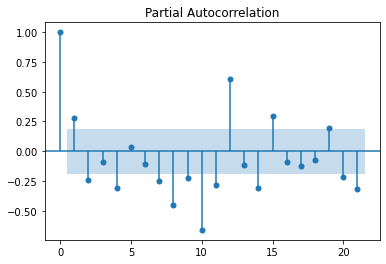

In [55]:
plot_pacf(train.diff().dropna());

The shaded area of the graph is the confidence interval. When the correlation drops into the shaded area, that means there is no longer statistically significant correlation between lags.

For an AR process, we run a linear regression on lags according to the order of the AR process. The coefficients calculated factor in the influence of the other variables.   

Since the PACF shows the direct effect of previous lags, it helps us choose AR terms.  If there is a significant positive value at a lag, consider adding an AR term according to the number that you see.

Some rules of thumb: 

    - A sharp drop after lag "k" suggests an AR-k model.
    - A gradual decline suggests an MA.

### ACF

The autocorrelation plot of our time series is simply a version of the correlation plots we used in linear regression.  Our features this time are prior points in the time series, or the **lags**. 

We can calculate a specific covariance ($\gamma_k$) with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y_t})(y_{t+k}-\bar{y_{t+k}})}$

In [56]:
lags = train.copy()
lags.columns = ['lag_0']
lags['lag_1'] = train.shift()
lags.head()

,lag_0,lag_1
Month,,
1949-01-01,112,NaN
1949-02-01,118,112.0
1949-03-01,132,118.0
1949-04-01,129,132.0
1949-05-01,121,129.0


In [57]:
gamma_1 = sum(((lags['lag_0'][1:]-lags['lag_0'][1:].mean()) *\
               (lags['lag_1'].dropna()-lags['lag_1'].dropna().mean())))/(len(lags['lag_1'])-1)
gamma_1

6872.374617870554

We then compute the Pearson correlation:

$\large\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

In [58]:
rho = gamma_1/(lags.lag_0[1:].std(ddof=0)*lags.lag_1.std(ddof=0))
rho

0.9539775834626815

In [59]:
lags = train.copy()
lags.columns = ['lag_0']
lags['lag_1'] = train.shift()
lags['lag_2'] = train.shift(2)
lags['lag_3'] = train.shift(3)
lags['lag_4'] = train.shift(4)
lags['lag_5'] = train.shift(5)
lags.corr()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
lag_0,1.000000,0.953978,0.881759,0.820048,0.775554,0.765355
lag_1,0.953978,1.000000,0.954042,0.879947,0.818712,0.779360
lag_2,0.881759,0.954042,1.000000,0.954719,0.884333,0.831974
lag_3,0.820048,0.879947,0.954719,1.000000,0.955819,0.890557
lag_4,0.775554,0.818712,0.884333,0.955819,1.000000,0.956578
lag_5,0.765355,0.779360,0.831974,0.890557,0.956578,1.000000


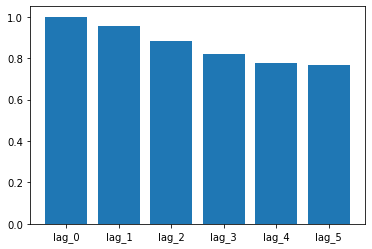

In [60]:
list(lags.corr()['lag_0'].index)
plt.bar(list(lags.corr()['lag_0'].index), list(lags.corr()['lag_0']));

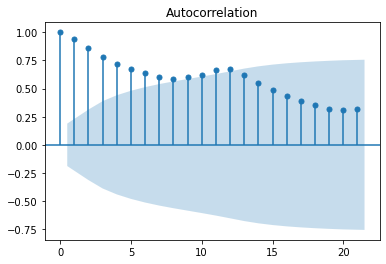

In [61]:
# Original data

plot_acf(lags['lag_0']);

The above autocorrelation shows that there is correlation between lags up to about 12 weeks back.  

When Looking at the ACF graph for the original data, we see a strong persistent correlation with higher order lags. This is evidence that we should take a **first difference** of the data to remove this autocorrelation.

This makes sense, since we are trying to capture the effect of recent lags in our ARMA models, and with high correlation between distant lags, our models will not come close to the true process.

Generally, we use an ACF to predict MA terms.
Moving Average models are using the error terms of the predictions to calculate the next value.  This means that the algorithm does not incorporate the direct effect of the previous value. It models what are sometimes called **impulses** or **shocks** whose effect accounts for the propogation of correlation from one lag to the other. 

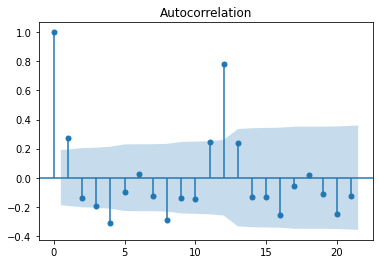

In [62]:
plot_acf(train.diff().dropna());

This autocorrelation plot can now be used to get an idea of a potential MA term.  Our differenced series shows negative significant correlation at a lag of 1, which suggests adding 1 MA term. There is also a statistically significant 2nd term, so adding another MA is another possibility.


> If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms. [Duke](https://people.duke.edu/~rnau/411arim3.htm#signatures)

Rule of thumb:
    
  - If the autocorrelation shows negative correlation at the first lag, try adding MA terms.
    
    

![alt text](images/armaguidelines.png)

The plots above suggest that we should try a 1st order differenced MA(1) or MA(2) model on our weekly gun offense data.

This aligns with our AIC scores from above.

The ACF can be used to identify the possible structure of time series data. That can be tricky going forward as there often isn’t a single clear-cut interpretation of a sample autocorrelation function.

Let's plot our training predictions, using an ARIMA model with order (1, 1, 2).

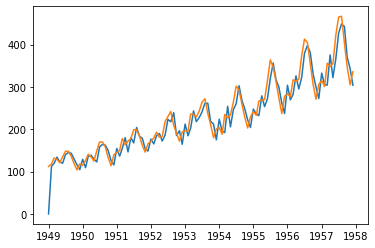

In [63]:
aa_model = ARIMA(train, order=(1, 1, 2)).fit()
y_hat_train = aa_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

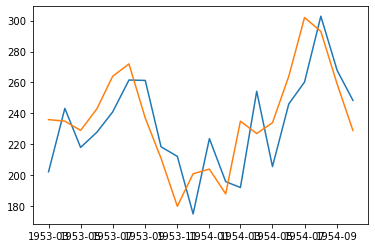

In [64]:
# Let's zoom in:

fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70]);

In [65]:
aa_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                  108
Model:                      ARIMA(1, 1, 2)   Log Likelihood                -487.070
Date:                     Tue, 26 Jul 2022   AIC                            982.140
Time:                             15:36:25   BIC                            992.831
Sample:                         01-01-1949   HQIC                           986.474
                              - 12-01-1957                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5258      0.123      4.269      0.000       0.284       0.767
ma.L1         -0.2263      0.123     -1.835      0.066      -0.468       0.015
ma.L2         -0.5436      0.086     -6.297      0.000      -0.713      -0.374
sigma2       523.1555     95.930      5.454      0.000     335.137     711.174
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 3.76
Prob(Q):                              0.63   Prob(JB):                         0.15
Heteroskedasticity (H):               4.70   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""